In [1]:
# import pandas as pd
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# from matplotlib.collections import LineCollection
# from f1tenth_benchmarks.utils.MapData import MapData
# from f1tenth_benchmarks.data_tools.plotting_utils import *
# from f1tenth_benchmarks.data_tools.process_data import process_data

# if os.getcwd().split('/')[-1] == 'benchmark_results':
#     os.chdir('..')
#     os.chdir('..')
#     print(f'Changed directory to root of repo: {os.getcwd()}')

# save_path = 'Data/BenchmarkArticle/'
# if not os.path.exists(save_path):
#     os.makedirs(save_path)
# process_data()

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
# Ensure these modules can be imported from the new location
from f1tenth_benchmarks.utils.MapData import MapData
from f1tenth_benchmarks.data_tools.plotting_utils import *
from f1tenth_benchmarks.data_tools.process_data import process_data

# Explicitly define the root of the repo based on the known structure of your working directory
repo_root = '/home/m810z573/Downloads/f1tenth_benchmarks/f1tenth_benchmarks'
print(f'Working from the repo root: {repo_root}')

# Now we use the repo_root for defining other paths
save_path = os.path.join(repo_root, 'Data', 'BenchmarkArticle')
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Assuming process_data() works with paths relative to the repo root, adjust if necessary
os.chdir(repo_root)  # Change the working directory to repo_root if required by process_data()
process_data()

Working from the repo root: /home/m810z573/Downloads/f1tenth_benchmarks/f1tenth_benchmarks
Complied Full.csv and Summary.csv.


# Load Data

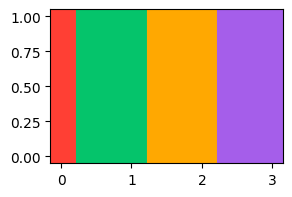

In [2]:
planners = ['GlobalPlanPP', "FollowTheGap", "EndToEnd", "TinyLidarNet"]
#planners = ['GlobalPlanPP', "GlobalPlanMPCC", "EndToEnd", "TinyLidarNet"]

# test_ids = ["benchmark"] * 4
test_ids = ["benchmark_pp", "benchmark_ftg", "benchmark_e2e_il", "benchmark_tiny_il"]
#test_ids = ["mu90_steps4", "mu90_steps4", "benchmark_drl", "benchmark_tinylidar"]


neat_planner_names = ["Opti. & tracking", "Follow-the-Gap", "End-to-end", "TinyLidarNet"]
#neat_planner_names = ["Opti. & tracking", "MPCC", "End-to-end", "TinyLidarNet"]

n_planners = len(planners)
map_list = ["example","MoscowRaceway"]

#planner_colors = [chrome_yellow, lighter_purple]
planner_colors = [red_orange, sweedish_green, chrome_yellow, lighter_purple]

plt.figure(figsize=(3, 2))
for i in range(n_planners):
    plt.plot([i, i], [0, 1], color=planner_colors[i], linewidth=80)
    

In [3]:
process_data()

summary_df = pd.read_csv("/home/m810z573/Downloads/f1tenth_benchmarks/f1tenth_benchmarks/benchmark_results/Logs/Summary.csv")
results_df = summary_df.loc[summary_df.Vehicle.isin(planners)]
results_df = results_df.loc[results_df.TestID.isin(test_ids)]

# print(results_df)

times_df = results_df[['Vehicle', 'MapName', 'AvgTime']]
times_df = times_df.pivot(index="Vehicle", columns="MapName", values="AvgTime")
times_df.columns = times_df.columns.str.upper()
times_df.rename(index=dict(zip(planners, neat_planner_names)), inplace=True)
times_df.sort_values(by="Vehicle", inplace=True, ascending=False)
print(times_df)

times_df.to_latex(f"{save_path}benchmark_laptimes.tex", float_format="%.2f")

Complied Full.csv and Summary.csv.


MapName           MOSCOWRACEWAY     AUT     ESP  EXAMPLE     GBR      MCO
Vehicle                                                                  
TinyLidarNet            53.9200     NaN  47.080   23.508  40.400      NaN
Opti. & tracking        47.5556  16.788  35.920   24.788  31.240  28.0800
Follow-the-Gap          61.7550  19.124  45.772   29.180  39.356  34.9289
End-to-end                  NaN     NaN     NaN      NaN     NaN      NaN


/tmp/ipykernel_40548/2191398937.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


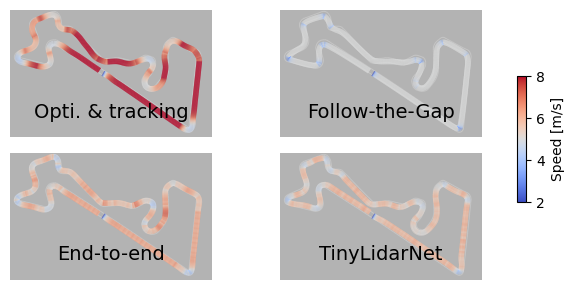

In [ ]:
plot_map = "MoscowRaceway"
lap_n = 3

map_data = MapData(plot_map)
lap_dfs = []

for i, planner_name in enumerate(planners):
    data = np.load(f"/home/m810z573/Downloads/f1tenth_benchmarks/f1tenth_benchmarks/benchmark_results/Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{plot_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
    df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
    df["planner"] = planner_name

    lap_dfs.append(df)
lap_df = pd.concat(lap_dfs)

fig, axs = plt.subplots(2, 2, figsize=(6., 3), sharex=True, sharey=True)
axs_list = axs.flatten()
for i in range(n_planners):
    plt.sca(axs_list[i])
    map_data.plot_map_img()

    df = lap_df[lap_df["planner"] == planners[i]]
    xs, ys = map_data.xy2rc(df.x, df.y)
    pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
    norm = plt.Normalize(2, 8)
    lc = LineCollection(segments, cmap='coolwarm', norm=norm)
    lc.set_array(df.speed.values)
    lc.set_linewidth(4)
    line = plt.gca().add_collection(lc)
    
    plt.axis('off')
    axs_list[i].set_aspect('equal')
    plt.xlim(100, 2000)
    plt.ylim(400, 1600)
    # plt.xlim(300, 1300)
    # plt.ylim(300, 1300)
    plt.text(0.5, 0.2, neat_planner_names[i], horizontalalignment='center', verticalalignment='center', transform=axs_list[i].transAxes, size=14)

ax = plt.gca()
cax = fig.add_axes([ax.get_position().x1+0.09, ax.get_position().y0+0.2, 0.015, ax.get_position().height*1.2])
plt.colorbar(line, cax=cax, label="Speed [m/s]", ticks=[2, 4, 6, 8])

plt.tight_layout()
plt.savefig(f"{save_path}speed_trajectories_{plot_map}.pdf", bbox_inches='tight')

In [4]:
map_name = "MoscowRaceway"
lap_n = 3
lap_dfs = []
for i, planner_name in enumerate(planners):
    data = np.load(f"/home/m810z573/Downloads/f1tenth_benchmarks/f1tenth_benchmarks/benchmark_results/Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{plot_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
    df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
    df["planner"] = planner_name
    lap_dfs.append(df)


lap_df = pd.concat(lap_dfs)
fig, ax1 = plt.subplots(1, 1, figsize=(6., 2.2), sharex=True)
map_data = MapData(plot_map)

for i in range(n_planners):
    df = lap_df[lap_df["planner"] == planners[i]]
    ax1.plot(df["progress"]*100, df["speed"], label=neat_planner_names[i], alpha=0.99, color=planner_colors[i], linewidth=2.4)

ax1.grid(True)
ax1.set_ylim(1., 8.5)
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

plt.legend(ncol=4, loc="center", bbox_to_anchor=(0.48, 1.15), fontsize=5)
plt.xlabel("Track progress [%]")
plt.ylabel("Speed [m/s]")

plt.tight_layout()
plt.savefig(f"{save_path}speed_comparison_{map_name}.pdf", bbox_inches='tight', pad_inches=0.0)
plt.savefig(f"{save_path}speed_comparison_{map_name}.svg", bbox_inches='tight', pad_inches=0.0)

NameError: name 'plot_map' is not defined

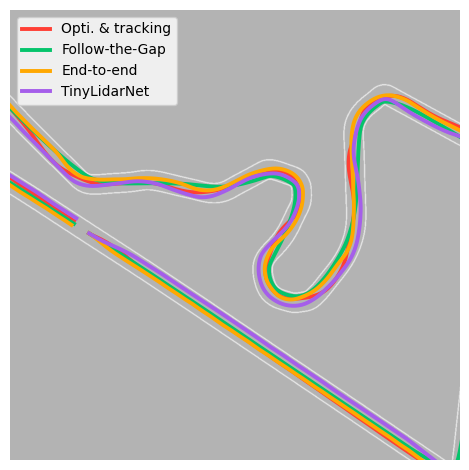

In [ ]:
plot_map = "MoscowRaceway"
lap_n = 3
lap_dfs = []
for i, planner_name in enumerate(planners):
    data = np.load(f"/home/m810z573/Downloads/f1tenth_benchmarks/f1tenth_benchmarks/benchmark_results/Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{plot_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
    df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
    df["planner"] = planner_name

    lap_dfs.append(df)
lap_df = pd.concat(lap_dfs)

map_data = MapData(plot_map)
map_data.plot_map_img()
for i in range(n_planners):
    df = lap_df[lap_df["planner"] == planners[i]]

    xs, ys = map_data.xy2rc(df.x, df.y)
    plt.plot(xs, ys, linewidth=2.8, color=planner_colors[i], label=neat_planner_names[i])
    
plt.axis('off')
plt.legend()
# plt.xlim(200, 1400)
# plt.ylim(400, 1300)
plt.xlim(800, 1800)
plt.ylim(500, 1500)

plt.tight_layout()
plt.savefig(f"{save_path}path_comparison_{plot_map}.svg", bbox_inches='tight', pad_inches=0)
plt.savefig(f"{save_path}path_comparison_{plot_map}.pdf", bbox_inches='tight', pad_inches=0)
